In [1]:

import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [2]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")
fabric.launch()
print(fabric.device)

cuda:0


In [3]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [4]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset_full.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list 
kp_dates = pd.read_csv("D:\\New folder (2)\\matched_kp_dates_full.csv")
kp_dates_list = kp_dates["date"].tolist() 

1097
1097
1097
1097
1099


In [5]:
# Get active indices
dataset_csv_file = pd.read_csv("D:\\New folder (2)\\dataset_full.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)
        
active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))
    
for dataloader in active_dataloaders:
    print(len(dataloader))

264
261
403
446
329


In [6]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
            
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [7]:
torch.cuda.empty_cache()

In [8]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1
            
    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):  
            
    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss
    
def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1





FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.602296749108584


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8136298825628445


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9447724791003946


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8254368045318106


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8986685226682005


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8181806776328233


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7391332696596635


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6667310322082831


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5338385198041633


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8989327715283506


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4267417416288413


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6384467108879217


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2590653362560111


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.793135334764317


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0942098581054458


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7416995015126384


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9725551176739057


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7532035126401713


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9040322950086636


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8191421746385736


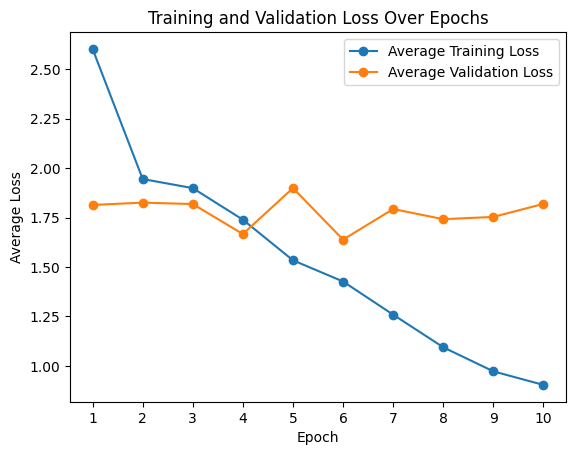

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.8191
RMSE: 1.3488
MSE: 1.8199
MAE: 1.0242
R²: -0.0045
R: 0.3214
True Skill Score: 0.3090
Accuracy: 0.7438
Precision: 0.4650
Recall: 0.4280
F1 Score: 0.4458


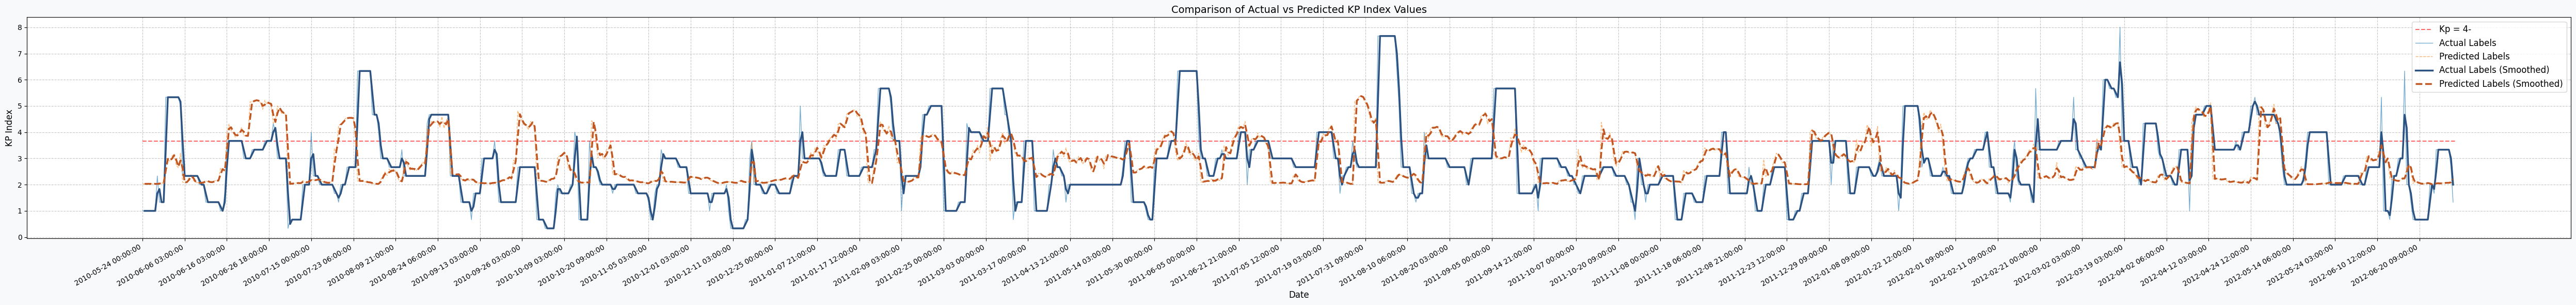

[2.03125, 2.03125, 2.03125, 2.03125, 2.03125, 2.03125, 2.03125, 2.03125, 2.046875, 2.0625, 2.046875, 3.015625, 2.953125, 2.890625, 3.09375, 3.15625, 2.734375, 2.640625, 3.203125, 2.09375, 2.078125, 2.109375, 2.25, 2.375, 2.171875, 2.09375, 2.078125, 2.0625, 2.078125, 2.09375, 2.15625, 2.109375, 2.09375, 2.09375, 2.140625, 2.15625, 2.15625, 2.640625, 2.546875, 2.515625, 3.953125, 4.3125, 4.0625, 3.984375, 3.8125, 3.9375, 3.984375, 4.1875, 3.859375, 3.875, 3.84375, 5.15625, 5.15625, 5.21875, 5.21875, 5.1875, 5.125, 4.875, 5.21875, 5.0625, 5.15625, 5.0, 4.34375, 4.4375, 5.0, 4.875, 4.71875, 4.75, 4.65625, 2.03125, 2.03125, 2.046875, 2.046875, 2.0625, 2.0625, 2.046875, 2.15625, 2.09375, 2.078125, 2.15625, 2.1875, 2.1875, 2.15625, 2.21875, 2.171875, 2.125, 2.09375, 2.078125, 2.0625, 2.09375, 2.109375, 3.375, 3.234375, 4.25, 4.3125, 4.40625, 4.5, 4.5625, 4.53125, 4.5625, 4.5, 3.765625, 2.140625, 2.140625, 2.140625, 2.140625, 2.09375, 2.09375, 2.078125, 2.046875, 2.03125, 2.03125, 2.03125, 2.

Testing Progress:   0%|          | 0/132 [00:00<?, ?it/s]

Average test loss: 4.0460
RMSE: 2.0115
MSE: 4.0460
MAE: 1.5010
R²: -2.7254
R: -0.1680
True Skill Score: 0.0000
Accuracy: 0.4280
Precision: 1.0000
Recall: 0.4280
F1 Score: 0.5995


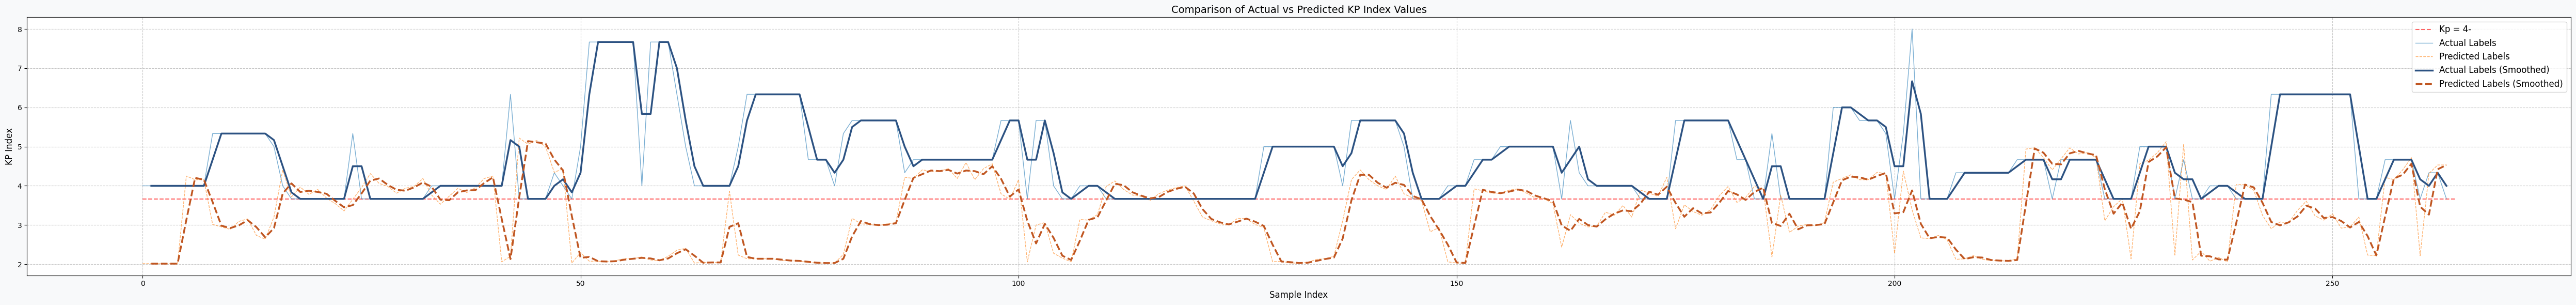

[2.015625, 2.015625, 2.015625, 2.015625, 2.015625, 4.25, 4.15625, 4.15625, 3.015625, 2.953125, 2.890625, 3.09375, 3.15625, 2.734375, 2.640625, 3.203125, 4.40625, 3.71875, 3.96875, 3.78125, 3.90625, 3.6875, 3.546875, 3.359375, 3.65625, 3.953125, 4.3125, 4.0625, 3.984375, 3.8125, 3.9375, 3.984375, 4.1875, 3.765625, 3.53125, 3.734375, 3.9375, 3.828125, 3.953125, 4.1875, 4.25, 2.0625, 2.203125, 5.21875, 5.0625, 5.15625, 5.0, 4.34375, 4.4375, 2.03125, 2.296875, 2.078125, 2.078125, 2.0625, 2.09375, 2.140625, 2.140625, 2.1875, 2.109375, 2.09375, 2.203125, 2.359375, 2.40625, 2.03125, 2.046875, 2.046875, 2.046875, 3.859375, 2.234375, 2.140625, 2.140625, 2.140625, 2.140625, 2.09375, 2.09375, 2.078125, 2.046875, 2.03125, 2.03125, 2.03125, 2.25, 3.171875, 3.03125, 3.015625, 2.984375, 3.03125, 3.0625, 4.21875, 4.1875, 4.40625, 4.375, 4.375, 4.4375, 4.1875, 4.59375, 4.15625, 4.4375, 4.5625, 3.796875, 3.65625, 4.15625, 2.0625, 3.0, 3.0625, 2.28125, 2.15625, 2.0625, 3.140625, 3.125, 3.265625, 3.984375

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.558465352539898


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.168777641187166


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8364367896910005


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1915607480934476


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.638344469020283


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.252377391810646


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5479152606837323


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.295419419255271


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4955061819483653


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.6590650062092016


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3616110608407035


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.967043857497006


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1990887335345684


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8042192842999487


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0821598566560884


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.178485643220828


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9314642261817977


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  3.002178257245796


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8590711273405046


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9344413404225587


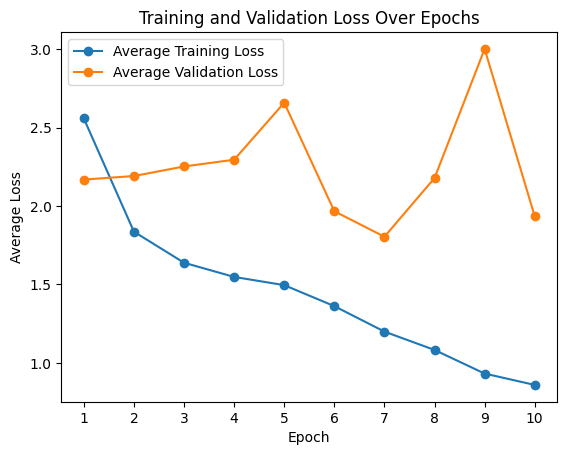

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9344
RMSE: 1.3908
MSE: 1.9362
MAE: 1.1245
R²: 0.0128
R: 0.2821
True Skill Score: 0.3687
Accuracy: 0.7530
Precision: 0.4679
Recall: 0.2797
F1 Score: 0.3501


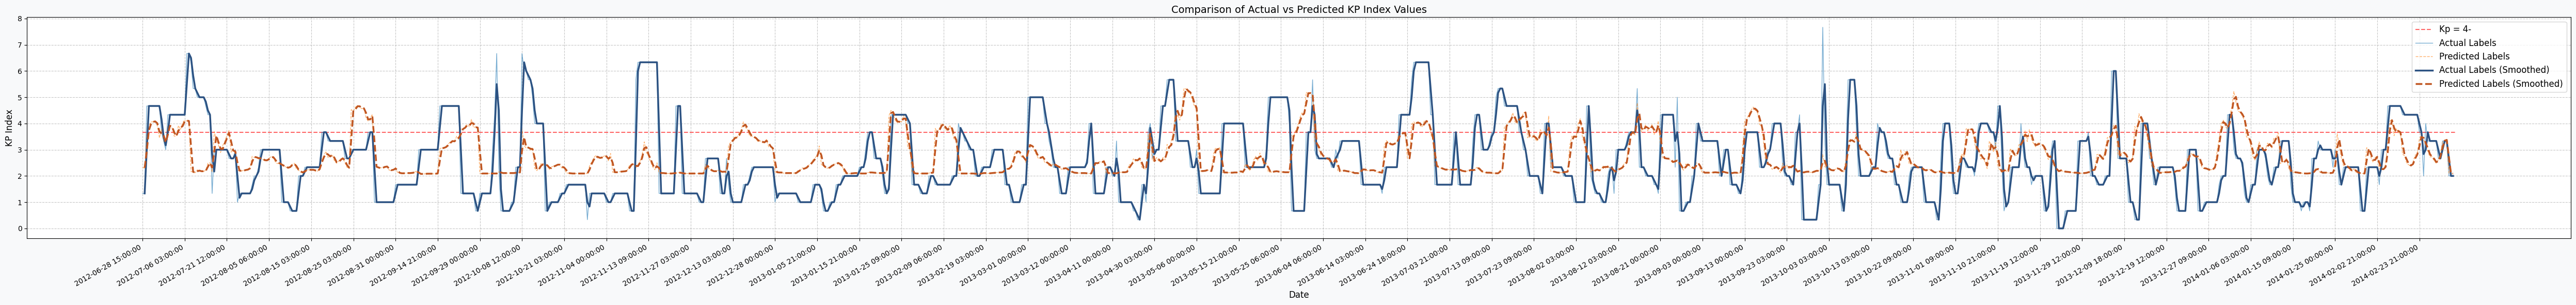

[2.328125, 2.296875, 3.578125, 3.890625, 4.0625, 4.0625, 4.09375, 3.921875, 3.453125, 3.78125, 3.328125, 3.234375, 3.90625, 3.921875, 3.828125, 3.515625, 3.515625, 3.921875, 3.765625, 4.03125, 4.125, 4.09375, 4.09375, 2.171875, 2.140625, 2.125, 2.234375, 2.171875, 2.1875, 2.171875, 2.21875, 2.484375, 2.5, 2.140625, 3.6875, 3.390625, 3.1875, 2.890625, 3.15625, 3.3125, 3.546875, 3.734375, 2.90625, 3.03125, 2.84375, 2.203125, 2.203125, 2.1875, 2.21875, 2.234375, 2.25, 2.328125, 2.75, 2.703125, 2.71875, 2.640625, 2.703125, 2.625, 2.578125, 2.609375, 2.671875, 2.734375, 2.703125, 2.53125, 2.46875, 2.5, 2.375, 2.40625, 2.34375, 2.28125, 2.390625, 2.4375, 2.484375, 2.265625, 2.21875, 2.140625, 2.125, 2.21875, 2.234375, 2.234375, 2.234375, 2.234375, 2.1875, 2.171875, 2.34375, 2.65625, 2.765625, 2.9375, 2.703125, 2.78125, 2.8125, 2.578125, 2.484375, 2.5625, 2.65625, 2.6875, 2.5, 2.328125, 2.296875, 4.53125, 4.46875, 4.625, 4.6875, 4.625, 4.5625, 4.59375, 4.21875, 4.09375, 4.21875, 4.34375, 2.34

Testing Progress:   0%|          | 0/131 [00:00<?, ?it/s]

Average test loss: 3.5510
RMSE: 1.8844
MSE: 3.5645
MAE: 1.6162
R²: -4.2675
R: 0.0487
True Skill Score: 0.0000
Accuracy: 0.2797
Precision: 1.0000
Recall: 0.2797
F1 Score: 0.4371


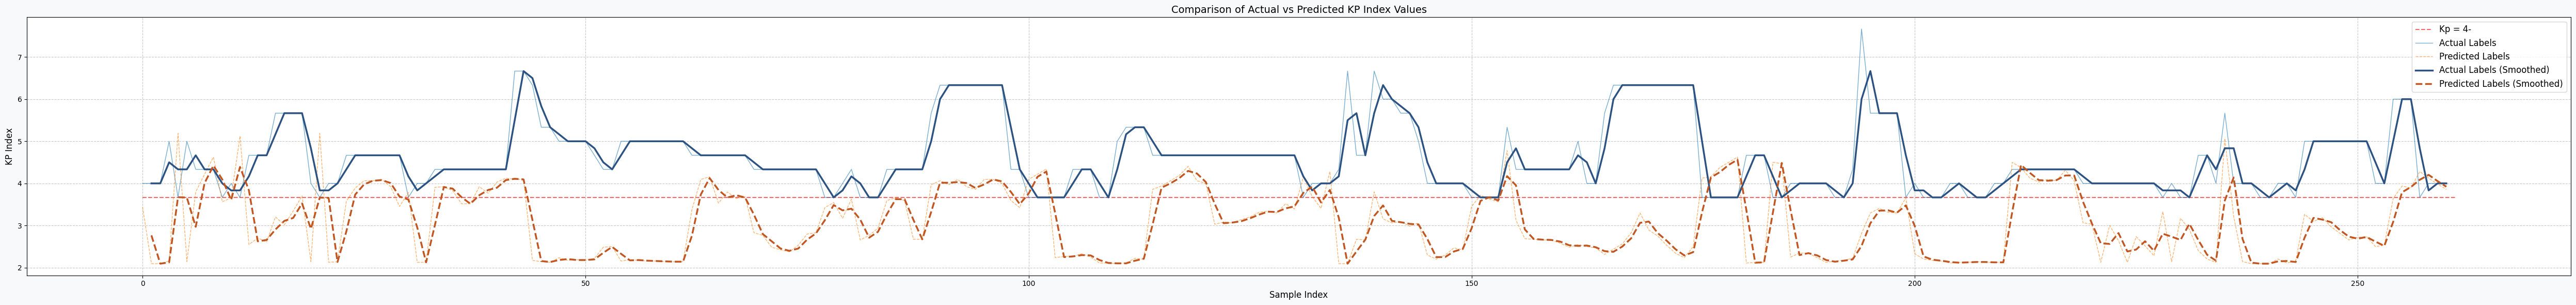

[3.4375, 2.09375, 2.09375, 2.15625, 5.1875, 2.140625, 3.796875, 4.21875, 4.625, 3.5625, 3.65625, 5.125, 2.546875, 2.703125, 2.609375, 3.203125, 3.015625, 3.34375, 3.703125, 2.140625, 5.1875, 2.125, 2.140625, 3.578125, 3.890625, 4.0625, 4.0625, 4.09375, 3.921875, 3.453125, 3.78125, 2.125, 2.125, 3.90625, 3.921875, 3.828125, 3.515625, 3.515625, 3.921875, 3.765625, 4.03125, 4.125, 4.09375, 4.09375, 2.171875, 2.140625, 2.125, 2.234375, 2.171875, 2.1875, 2.171875, 2.21875, 2.484375, 2.5, 2.15625, 2.1875, 2.171875, 2.15625, 2.15625, 2.140625, 2.140625, 2.140625, 3.375, 4.09375, 4.15625, 3.53125, 3.796875, 3.640625, 3.6875, 2.828125, 2.765625, 2.484375, 2.421875, 2.375, 2.53125, 2.796875, 2.828125, 3.421875, 3.546875, 3.171875, 3.625, 2.65625, 2.765625, 2.9375, 3.59375, 3.65625, 3.59375, 2.671875, 2.671875, 3.96875, 4.0625, 3.96875, 4.09375, 3.921875, 3.859375, 4.09375, 4.09375, 4.0, 3.59375, 3.421875, 4.09375, 4.21875, 4.34375, 2.234375, 2.265625, 2.265625, 2.328125, 2.25, 2.109375, 2.109375

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.5057830305517586


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.954490467393686


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8924308383137391


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8055872800802382


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7338860381741095


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7866337060196402


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.554817778484552


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7628836043587548


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4716321627162334


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.960433911082088


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2808191557506583


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7692725733698655


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1571257723192525


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.002369317170873


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0315478744667612


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9343580241377198


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9388152580892303


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9892879054018167


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.827968990007269


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9411560904072642


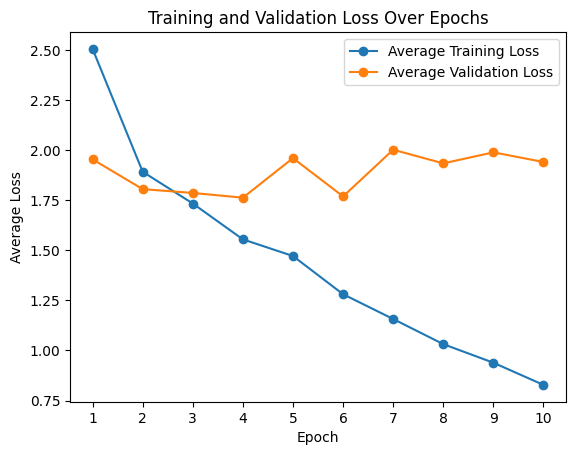

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9412
RMSE: 1.3933
MSE: 1.9427
MAE: 1.0752
R²: -0.0297
R: 0.2381
True Skill Score: 0.4554
Accuracy: 0.6718
Precision: 0.5923
Recall: 0.3424
F1 Score: 0.4340


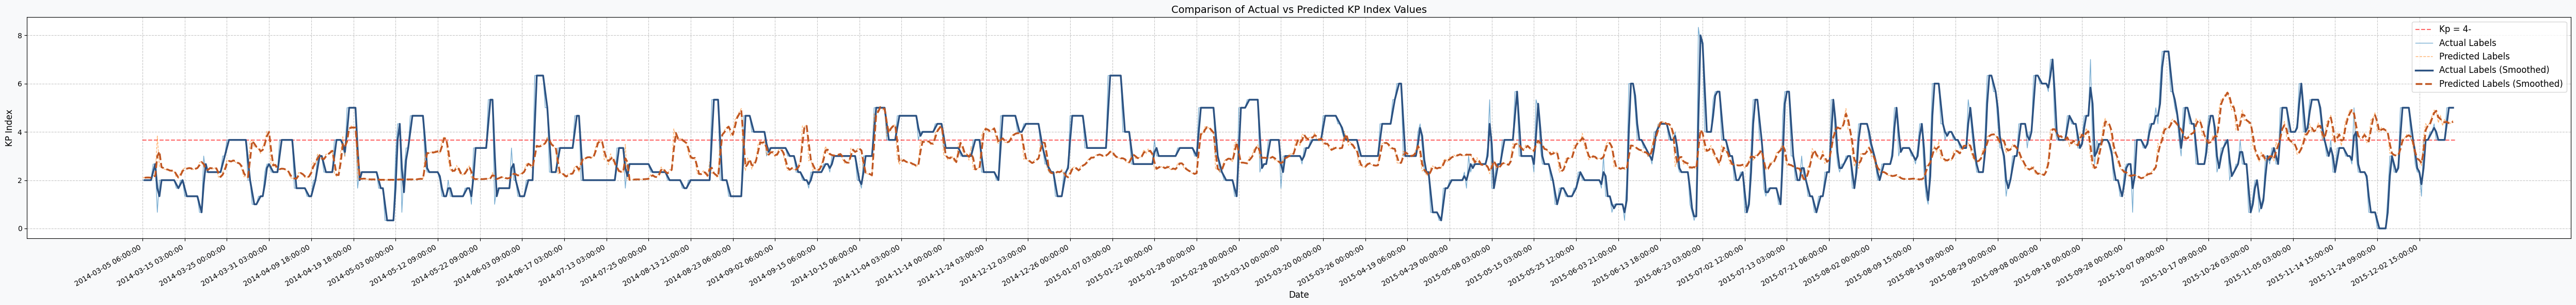

[2.09375, 2.109375, 2.109375, 2.109375, 2.09375, 2.203125, 2.140625, 3.828125, 2.546875, 2.53125, 2.46875, 2.4375, 2.4375, 2.359375, 2.421875, 2.359375, 2.125, 2.09375, 2.296875, 2.453125, 2.5, 2.453125, 2.546875, 2.4375, 2.4375, 2.5, 2.5, 2.734375, 2.765625, 2.578125, 2.390625, 2.453125, 2.546875, 2.4375, 2.5, 2.484375, 2.125, 2.140625, 2.3125, 2.53125, 2.828125, 2.765625, 2.78125, 2.84375, 2.75, 2.703125, 2.671875, 2.484375, 2.140625, 2.15625, 2.09375, 3.578125, 3.671875, 3.359375, 3.40625, 3.28125, 3.109375, 3.390625, 3.609375, 4.03125, 3.96875, 2.5, 2.71875, 2.546875, 2.4375, 2.46875, 2.484375, 2.453125, 2.421875, 2.359375, 2.109375, 2.078125, 2.0625, 2.0625, 2.3125, 2.28125, 2.21875, 2.109375, 2.09375, 2.21875, 2.375, 2.734375, 2.703125, 3.078125, 3.0, 2.84375, 2.890625, 3.078125, 3.0625, 3.21875, 3.21875, 2.28125, 2.15625, 2.265625, 3.1875, 3.796875, 2.984375, 4.21875, 4.09375, 4.25, 4.125, 4.21875, 2.0625, 2.046875, 2.0625, 2.0625, 2.046875, 2.03125, 2.03125, 2.03125, 2.03125, 2

Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 2.8558
RMSE: 1.6899
MSE: 2.8622
MAE: 1.3722
R²: -2.5915
R: 0.0417
True Skill Score: 0.0000
Accuracy: 0.3424
Precision: 1.0000
Recall: 0.3424
F1 Score: 0.5102


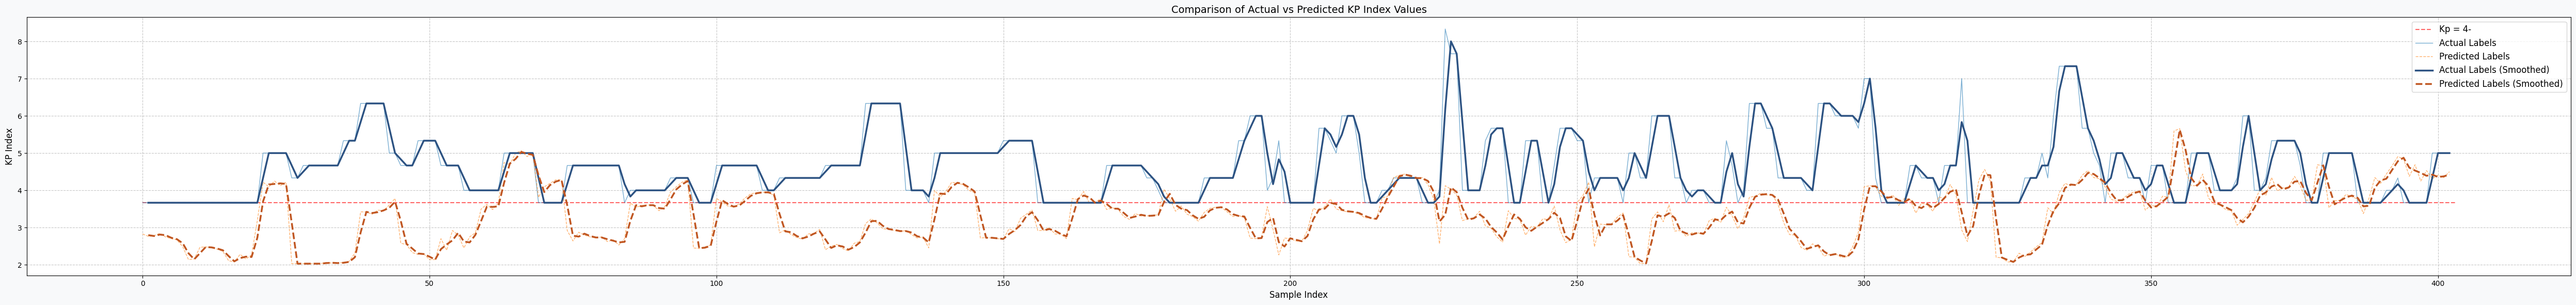

[2.828125, 2.765625, 2.78125, 2.84375, 2.75, 2.703125, 2.671875, 2.484375, 2.140625, 2.15625, 2.46875, 2.484375, 2.453125, 2.421875, 2.359375, 2.109375, 2.078125, 2.28125, 2.15625, 2.265625, 3.1875, 4.21875, 4.09375, 4.25, 4.125, 4.21875, 2.03125, 2.03125, 2.03125, 2.03125, 2.03125, 2.03125, 2.0625, 2.046875, 2.046875, 2.0625, 2.09375, 2.3125, 3.421875, 3.421875, 3.359375, 3.46875, 3.453125, 3.609375, 3.78125, 2.578125, 2.546875, 2.328125, 2.28125, 2.296875, 2.140625, 2.140625, 2.703125, 2.390625, 2.921875, 2.796875, 2.453125, 2.75, 2.859375, 3.5, 3.625, 3.484375, 3.65625, 4.75, 4.6875, 5.0, 5.0625, 4.90625, 5.0, 3.8125, 4.09375, 4.1875, 4.28125, 4.28125, 2.921875, 2.640625, 2.875, 2.796875, 2.75, 2.71875, 2.75, 2.625, 2.671875, 2.53125, 2.703125, 3.65625, 3.546875, 3.59375, 3.609375, 3.59375, 3.453125, 3.5625, 3.953125, 4.09375, 4.21875, 4.28125, 2.453125, 2.4375, 2.484375, 2.53125, 3.78125, 3.6875, 3.578125, 3.546875, 3.640625, 3.796875, 3.90625, 3.9375, 3.953125, 3.9375, 3.875, 2.85

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.4841914683195885


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9532162577341325


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9176255996032472


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9051049724424798


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8895055244066616


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8148508304814877


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8225423154532527


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7272161345435348


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7037795589692628


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7230769278807523


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5901577183070108


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6137933719142952


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.444093380027036


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.571511376234478


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.336609982744449


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5755034114674364


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1957726042906505


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8181484396213612


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0792047754878917


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6056518613852697


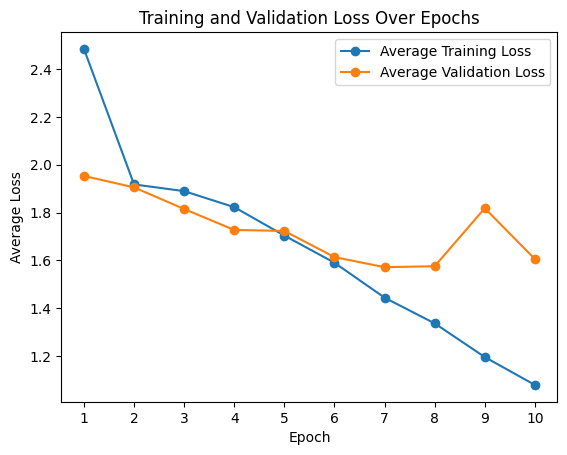

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.6057
RMSE: 1.2671
MSE: 1.6071
MAE: 1.0049
R²: 0.1240
R: 0.4351
True Skill Score: 0.2579
Accuracy: 0.6591
Precision: 0.5744
Recall: 0.6233
F1 Score: 0.5978


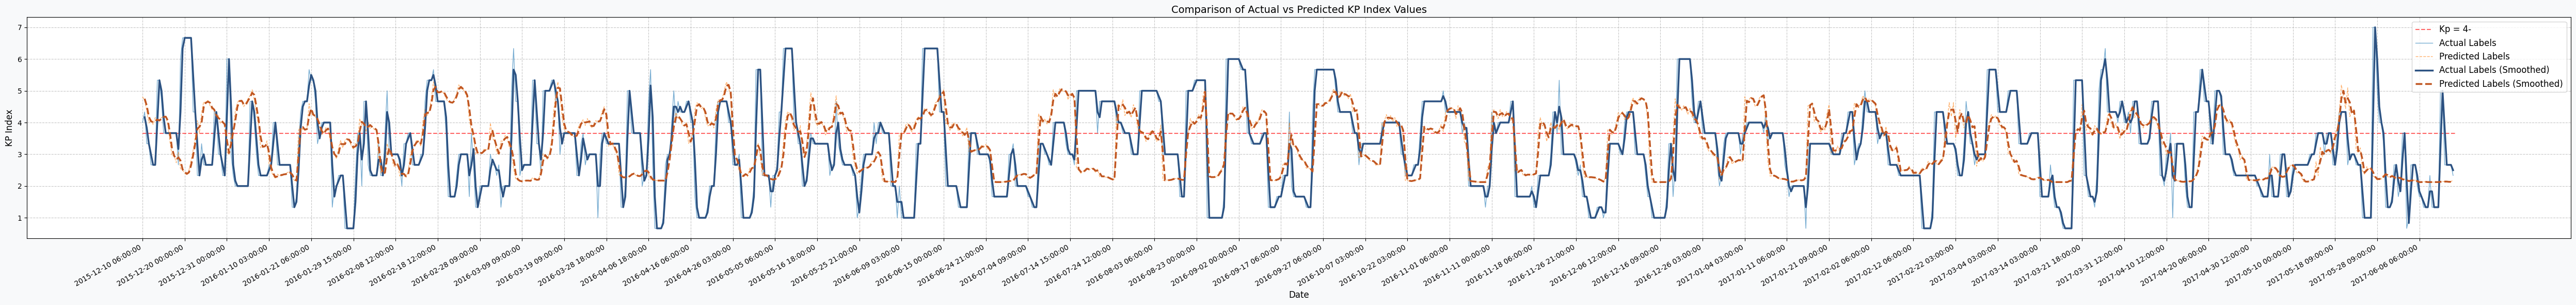

[4.8125, 4.6875, 4.375, 3.984375, 4.09375, 3.9375, 4.15625, 4.03125, 4.09375, 4.15625, 4.1875, 4.1875, 3.9375, 3.390625, 2.953125, 2.953125, 2.734375, 3.0625, 2.546875, 2.5, 2.40625, 2.359375, 2.5, 2.796875, 3.140625, 3.546875, 4.0625, 3.671875, 4.3125, 4.65625, 4.59375, 4.71875, 4.53125, 4.40625, 4.40625, 4.0625, 4.21875, 3.96875, 4.0625, 3.828125, 3.09375, 2.984375, 3.65625, 3.75, 4.375, 4.625, 4.71875, 4.65625, 4.5, 4.625, 4.75, 4.84375, 5.03125, 4.71875, 4.3125, 3.90625, 3.203125, 3.265625, 3.234375, 3.421875, 2.703125, 2.46875, 2.328125, 2.234375, 2.375, 2.3125, 2.375, 2.359375, 2.390625, 2.4375, 2.421875, 2.296875, 2.171875, 2.171875, 3.75, 3.953125, 3.765625, 3.78125, 3.8125, 4.59375, 4.28125, 4.21875, 4.1875, 4.03125, 3.84375, 3.625, 3.671875, 3.84375, 3.78125, 3.4375, 3.015625, 3.0, 2.859375, 3.203125, 3.4375, 3.203125, 3.4375, 3.5, 3.421875, 3.28125, 3.15625, 3.34375, 3.328125, 4.125, 3.921875, 4.0, 3.703125, 4.03125, 3.8125, 3.890625, 3.765625, 3.765625, 2.875, 2.4375, 2.343

Testing Progress:   0%|          | 0/223 [00:00<?, ?it/s]

Average test loss: 1.8802
RMSE: 1.3712
MSE: 1.8802
MAE: 1.0651
R²: -1.9615
R: 0.1018
True Skill Score: 0.0000
Accuracy: 0.6233
Precision: 1.0000
Recall: 0.6233
F1 Score: 0.7680


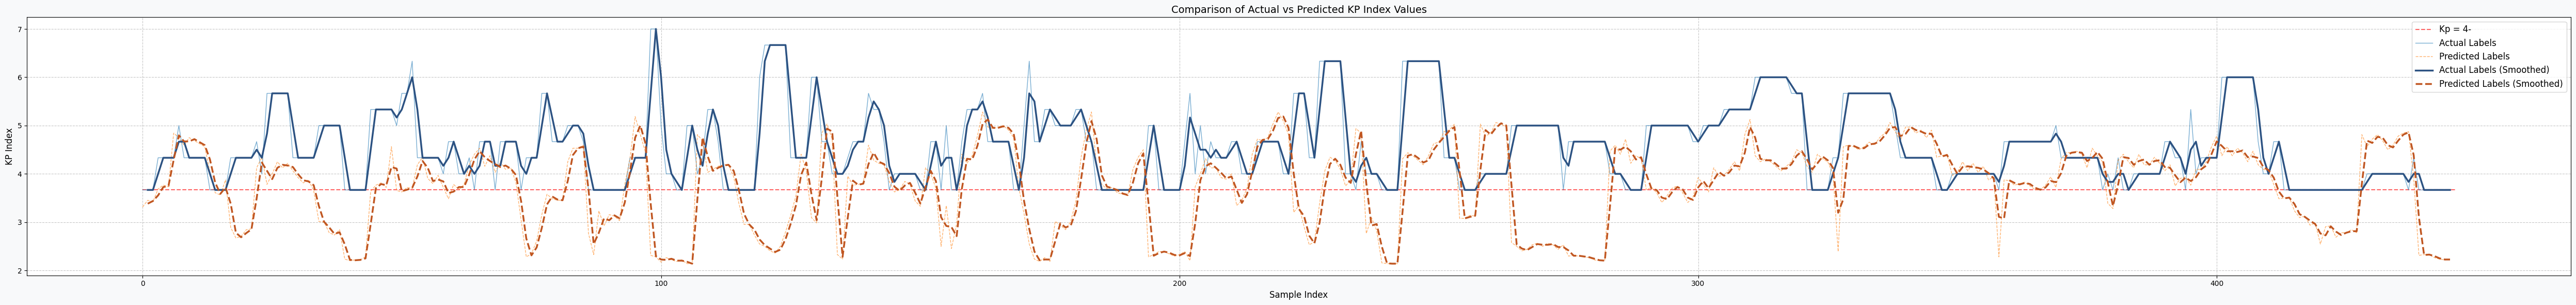

[3.3125, 3.453125, 3.421875, 3.6875, 3.765625, 3.734375, 4.84375, 4.75, 4.59375, 4.75, 4.6875, 4.625, 4.5625, 4.03125, 3.609375, 3.5625, 3.875, 2.890625, 2.671875, 2.703125, 2.84375, 2.859375, 4.125, 4.34375, 3.78125, 4.0, 4.25, 4.125, 4.21875, 4.0625, 3.921875, 3.8125, 3.875, 3.65625, 3.015625, 3.0, 2.78125, 2.734375, 2.84375, 2.234375, 2.203125, 2.21875, 2.21875, 2.28125, 3.640625, 3.765625, 3.8125, 3.71875, 4.5625, 3.65625, 3.625, 3.71875, 3.703125, 4.1875, 4.34375, 3.90625, 3.796875, 3.96875, 3.71875, 3.484375, 3.78125, 3.671875, 3.78125, 4.1875, 4.40625, 4.53125, 4.15625, 4.375, 4.03125, 4.25, 4.09375, 4.125, 3.828125, 3.046875, 2.28125, 2.34375, 2.609375, 3.15625, 3.578125, 3.484375, 3.453125, 3.453125, 4.25, 4.53125, 4.53125, 4.59375, 2.765625, 2.328125, 3.234375, 2.921875, 3.15625, 3.125, 3.03125, 3.78125, 4.3125, 5.1875, 4.8125, 4.4375, 2.3125, 2.28125, 2.171875, 2.265625, 2.21875, 2.1875, 2.21875, 2.140625, 2.140625, 4.8125, 4.6875, 4.03125, 4.09375, 4.15625, 4.1875, 4.1875, 

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.567647754648529


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.7621586753563447


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.9737790867411629


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.772088616619056


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.9130220233395683


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6381692179729659


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.7947383329154405


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4917235109797515


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6321725958017819


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4241919257969526


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.5260633697694204


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3959287802467588


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.3729119230136426


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4504865458660787


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.2418611794379093


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4803075111582373


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.0899668584064164


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.7501427769469393


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.9766895928474753


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.56494598211837


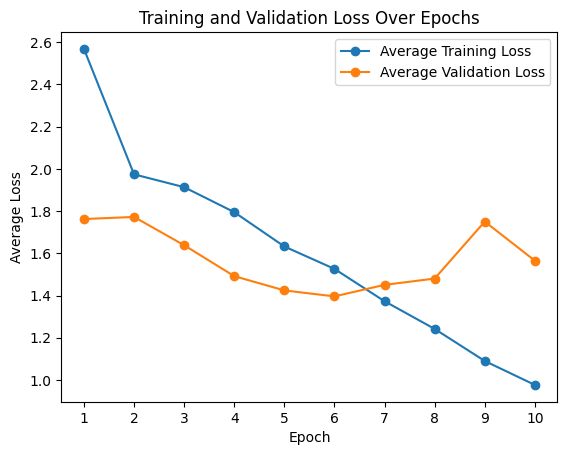

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.5649
RMSE: 1.2510
MSE: 1.5661
MAE: 0.9972
R²: 0.1116
R: 0.3508
True Skill Score: 0.4634
Accuracy: 0.7061
Precision: 0.5283
Recall: 0.1702
F1 Score: 0.2575


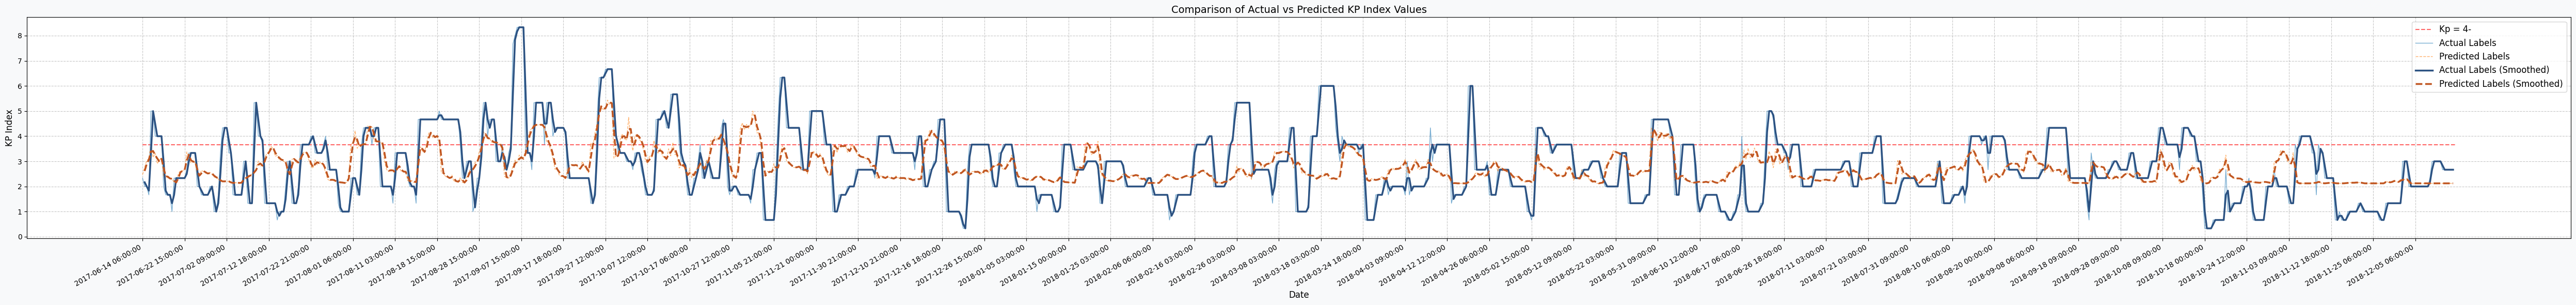

[2.46875, 2.765625, 3.03125, 3.109375, 3.671875, 3.15625, 3.328125, 2.90625, 3.0625, 3.140625, 2.375, 2.4375, 2.34375, 2.296875, 2.3125, 2.15625, 2.15625, 2.5, 2.625, 2.625, 2.6875, 3.375, 3.15625, 2.9375, 3.03125, 2.9375, 2.453125, 2.40625, 2.640625, 2.59375, 2.53125, 2.5, 2.5625, 2.484375, 2.375, 2.359375, 2.296875, 2.203125, 2.203125, 2.203125, 2.21875, 2.1875, 2.140625, 2.140625, 2.15625, 2.140625, 2.140625, 2.15625, 2.359375, 2.296875, 2.453125, 2.40625, 2.5, 2.609375, 2.703125, 3.015625, 2.8125, 2.84375, 3.140625, 3.296875, 3.390625, 3.59375, 3.515625, 3.203125, 3.234375, 3.046875, 3.078125, 3.015625, 2.921875, 2.40625, 2.5625, 3.078125, 3.109375, 2.9375, 2.96875, 3.1875, 3.328125, 3.375, 3.3125, 3.0625, 2.8125, 2.71875, 3.0625, 2.859375, 3.0, 2.90625, 2.828125, 2.546875, 2.28125, 2.234375, 2.296875, 2.21875, 2.203125, 2.15625, 2.171875, 2.140625, 2.140625, 2.15625, 2.46875, 3.6875, 3.734375, 4.21875, 3.515625, 3.640625, 3.65625, 3.703125, 3.671875, 4.40625, 4.34375, 4.375, 3.812

Testing Progress:   0%|          | 0/165 [00:00<?, ?it/s]

Average test loss: 2.8535
RMSE: 1.6892
MSE: 2.8556
MAE: 1.4394
R²: -2.6952
R: 0.3618
True Skill Score: 0.0000
Accuracy: 0.1702
Precision: 1.0000
Recall: 0.1702
F1 Score: 0.2909


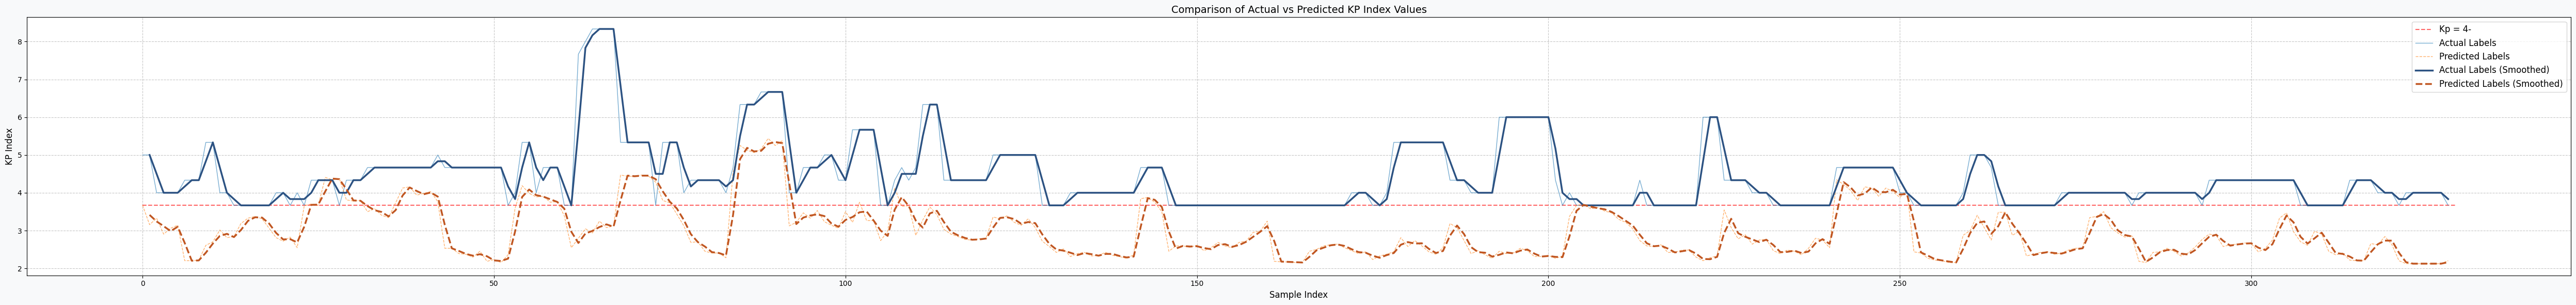

[3.671875, 3.15625, 3.328125, 2.90625, 3.0625, 3.140625, 2.203125, 2.203125, 2.21875, 2.609375, 2.703125, 3.015625, 2.8125, 2.84375, 3.1875, 3.328125, 3.375, 3.3125, 3.0625, 2.8125, 2.71875, 2.828125, 2.546875, 3.65625, 3.703125, 3.671875, 4.40625, 4.34375, 4.375, 3.8125, 3.78125, 3.796875, 3.5, 3.578125, 3.40625, 3.34375, 3.734375, 4.125, 4.15625, 3.9375, 3.984375, 4.03125, 3.765625, 2.53125, 2.53125, 2.390625, 2.375, 2.296875, 2.453125, 2.1875, 2.234375, 2.15625, 2.359375, 3.59375, 4.1875, 3.984375, 3.890625, 3.90625, 3.75, 3.765625, 3.390625, 2.546875, 2.796875, 3.046875, 2.9375, 3.25, 3.078125, 3.125, 4.46875, 4.4375, 4.4375, 4.46875, 4.4375, 4.28125, 3.796875, 3.734375, 3.4375, 3.125, 2.6875, 2.703125, 2.453125, 2.40625, 2.40625, 2.28125, 4.53125, 5.25, 5.125, 5.0625, 5.15625, 5.4375, 5.25, 5.375, 3.125, 3.21875, 3.46875, 3.328125, 3.53125, 3.234375, 3.140625, 3.0625, 3.5, 3.21875, 3.75, 3.265625, 3.265625, 2.734375, 2.984375, 4.125, 3.640625, 3.65625, 2.875, 3.28125, 3.625, 3.421

In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True)
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')


